# Assignment 1
**Authors:**
- **Student 1:**  Michele Carusone, michele.carusone@studio.unibo.it
- **Student 2:**  Norberto Casarin, norberto.casarin@studio.unibo.it
- **Student 3:**  Antonio Gravina, antonio.gravina@studio.unibo.it
- **Student 4:**  Gabriele Nanni, gabriele.nanni4@studio.unibo.it

# Weights

The weights are available at this link:
https://liveunibo-my.sharepoint.com/:f:/g/personal/gabriele_nanni4_studio_unibo_it/EoObM49LyvRNtzSMKxo8mwIBJSkfKZQFxrXwpIzXEwPmyg?e=93gM5s

# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



First of all we proceed importing the useful libraries for this task.

In [1]:
import torch
import pandas as pd
import re
import spacy
import numpy as np
from rapidfuzz import process, fuzz
from scipy.spatial.distance import cosine
from scipy.stats import mode
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset
import evaluate
from transformers import TrainingArguments
from transformers import Trainer
import os

Before starting, we check if CUDA is available.

In [2]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# Get the name of the GPU
if cuda_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_name}")

CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


After downlaoding the data, we load the three JSON files and encode them as pandas dataframes.

In [3]:
test_df = pd.read_json('data/test.json')
training_df = pd.read_json('data/training.json')
validation_df = pd.read_json('data/validation.json')

Let's explore the data structure of the three sets.

In [4]:
print('Test data shape:', test_df.shape)
print('Training data shape:', training_df.shape)
print('Validation data shape:', validation_df.shape)

Test data shape: (11, 312)
Training data shape: (11, 6920)
Validation data shape: (11, 726)


We want to swap the rows with the columns to have a better visualization of the data.

In [5]:
test_df = test_df.transpose().reset_index(drop=True)
training_df = training_df.transpose().reset_index(drop=True)
validation_df = validation_df.transpose().reset_index(drop=True)

test_df.set_index('id_EXIST', inplace=True)
training_df.set_index('id_EXIST', inplace=True)
validation_df.set_index('id_EXIST', inplace=True)

Let's have a quick look at the first 5 rows of the training set.

In [6]:
training_df.head()

,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
id_EXIST,,,,,,,,,,
100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


We also need to define the labels for the three sets. Since the original dataset uses six annotators, we can use the majority voting to assign the labels. We can use the `mode` function from the `scipy` library. Moreover, YES will be encoded as 1 and NO as 0.

In [7]:
training_df['labels_task1'] = training_df['labels_task1'].apply(lambda x: [1 if label == 'YES' else 0 for label in x])
test_df['labels_task1'] = test_df['labels_task1'].apply(lambda x: [1 if label == 'YES' else 0 for label in x])
validation_df['labels_task1'] = validation_df['labels_task1'].apply(lambda x: [1 if label == 'YES' else 0 for label in x])

In [8]:
np.random.seed(42)

def get_mode(array: list) -> float:
    '''
    Returns the mode of the given array.

    Parameters:
    array (list): The array to find the mode for.

    Returns:
    float: The mode of the array.
    '''
    mode_result = mode(array)
    return mode_result

training_df['hard_label_task1'] = training_df['labels_task1'].apply(get_mode)
test_df['hard_label_task1'] = test_df['labels_task1'].apply(get_mode)
validation_df['hard_label_task1'] = validation_df['labels_task1'].apply(get_mode)

We delete the rows with no clear majority.

In [9]:
training_df = training_df[training_df['hard_label_task1'].apply(lambda x: x[1] != 3)]
test_df = test_df[test_df['hard_label_task1'].apply(lambda x: x[1] != 3)]
validation_df = validation_df[validation_df['hard_label_task1'].apply(lambda x: x[1] != 3)]

And we do not consider the count of the mode.

In [10]:
training_df['hard_label_task1'] = training_df['hard_label_task1'].apply(lambda x: x[0])
test_df['hard_label_task1'] = test_df['hard_label_task1'].apply(lambda x: x[0])
validation_df['hard_label_task1'] = validation_df['hard_label_task1'].apply(lambda x: x[0])

We now drop all the non necessary columns.

In [11]:
training_df = training_df.drop(['number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2', 'labels_task3', 'split'], axis=1)
validation_df = validation_df.drop([ 'number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2', 'labels_task3', 'split'], axis=1)
test_df = test_df.drop(['number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2', 'labels_task3', 'split'], axis=1)

We filter tha dataset with only the english tweets.

In [12]:
en_test_df = test_df[test_df['lang'] == 'en']
en_training_df = training_df[training_df['lang'] == 'en']
en_validation_df = validation_df[validation_df['lang'] == 'en']

We show the structure of the dataset to check if all the changes were successful.

In [13]:
en_test_df.head()

,lang,tweet,hard_label_task1
id_EXIST,,,
400178,en,1st day at the pool on a beautiful Sunday in N...,0
400179,en,“I like your outfit too except when i dress up...,1
400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",0
400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,1
400182,en,@ultshunnie u gotta say some shit like “i’ll f...,1


-------------

# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.


To clean the data, we can use the `re` and `spacy` libraries.

We also need to download the necessary spacy models.

In [28]:
%%capture
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm

Now we can create a function named `preprocess` that takes a string as input and returns the cleaned text. We also use `process_text` to apply the function to the `tweet` column of the three dataframes.

In [29]:
# Load spaCy models once
nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load('es_core_news_sm')

def preprocess(text: str, model: spacy.lang) -> str:
    '''
    Removes emojis, hashtags, mentions, URLs, special characters, symbols and quote characters. Lemmatizes the text.

    Parameters:
    text (str): The text to be cleaned.
    model (spacy.lang): The spaCy model to use for lemmatization.

    Returns:
    str: The cleaned text.

    '''
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove emojis
    emoji_pattern = re.compile(
        "[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF" u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F" u"\U0001F780-\U0001F7FF" u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF" u"\U0001FA00-\U0001FA6F" u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0" u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove hashtags and mentions
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)

    # Remove special characters and symbols but keep accented letters
    text = re.sub(r'[^\w\sáéíóúÁÉÍÓÚüÜñÑ]', '', text)

    # Remove quotation marks
    text = re.sub(r'["\']', '', text)

    # Lemmatize the text
    doc = model(text)
    text = ' '.join([token.lemma_ for token in doc])

    return text

def process_text(text: str, lang: str) -> str:
    '''
    Preprocesses the given text.

    Parameters:
    text (str): The text to be cleaned.
    lang (str): The language of the text. Either 'en' for English or 'es' for Spanish.

    Returns:
    str: The cleaned text.
    '''
    model = nlp_en if lang == 'en' else nlp_es
    return preprocess(text, model)

Let's test the function on a single tweet, both in English and Spanish.

In [30]:
test_str = '@Twitter Hello There! My name is John and I like watching football. #good #morning www.google.it http://youtube.com 😊'
print(process_text(test_str, 'en'))
test_str = '@Twitter ¡Hola! Mi nombre es John y me gusta ver fútbol. #buenos #días www.google.it http://youtube.com 😊'
print(process_text(test_str, 'es'))

  hello there my name be John and I like watch football     
  Hola mi nombre ser John y yo gustar ver fútbol     


Now we can apply the function to the `tweet` column of the three sets.

In [31]:
en_test_df['tweet'] = en_test_df.apply(lambda row: process_text(row['tweet'], 'en'), axis=1)
print("Test data cleaned.")

en_training_df['tweet'] = en_training_df.apply(lambda row: process_text(row['tweet'], 'en'), axis=1)
print("Training data cleaned.")

en_validation_df['tweet'] = en_validation_df.apply(lambda row: process_text(row['tweet'], 'en'), axis=1)
print("Validation data cleaned.")

Test data cleaned.


C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\50681708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_training_df['tweet'] = en_training_df.apply(lambda row: process_text(row['tweet'], 'en'), axis=1)


Training data cleaned.
Validation data cleaned.


C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\50681708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_validation_df['tweet'] = en_validation_df.apply(lambda row: process_text(row['tweet'], 'en'), axis=1)


For now, we just want to use the English tweets.

In [32]:
print('English test data shape:', en_test_df.shape)
print('English training data shape:', en_training_df.shape)
print('English validation data shape:', en_validation_df.shape)

English test data shape: (286, 3)
English training data shape: (2870, 3)
English validation data shape: (158, 3)


We store a copy of the dataset for the Transformer part.

In [33]:
en_train_df_t = en_training_df.copy()
en_val_df_t = en_validation_df.copy()
en_test_df_t = en_test_df.copy()

To help us confront the predictions with the actual labels we convert the "YES" and "NO" labels to 1 and 0 considering the mode.

-------------

# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




Our first step is to load the GloVe embeddings. We'll use the 200-dimensional embeddings.

In [34]:
EMB_DIM = 200

We load the embeddings and store them in a dictionary. We'll use the `glove.twitter.27B.200d.txt` file, since it contains Twitter-specific embeddings.

In [35]:
token_to_emb = dict()

with open('glove_emb/glove.twitter.27B.200d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        if len(vector) == EMB_DIM:
            token_to_emb[word] = vector

Now we check if every word in the training set is in the GloVe embeddings.

In [36]:
en_training_df['tweet'] = en_training_df['tweet'].apply(lambda x: x.split())
all_tokens = np.array([token.lower() for tweet in en_training_df['tweet'] for token in tweet])
not_embedded = set(all_tokens[~np.isin(all_tokens, list(token_to_emb.keys()))])

print('Number of tokens not embedded:', len(not_embedded))

C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\615228579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_training_df['tweet'] = en_training_df['tweet'].apply(lambda x: x.split())


Number of tokens not embedded: 1917


Since we have some OOV tokens, we need to add them to the vocabulary and assign them a custom embedding. We can use a random embedding for this purpose, but we would lose the semantic information of the words. Since some words are similar to others (typos, abbreviations, etc.), we can use fuzzy matching to find the most similar word in the GloVe embeddings. 

For this purpose, we can use the `rapidfuzz` library. It is a fast string matching library that uses the Levenshtein distance to find a similarity score for words.

In [37]:
MIDPOINT = 70
OOV_token_to_emb = dict()
np.random.seed(42)

def sigmoid(x: float, steepness: float, midpoint: float) -> float:
    '''
    Sigmoid function with a given steepness and midpoint.

    Parameters:
    x (float): The input value.
    steepness (float): The steepness of the sigmoid function.
    midpoint (float): The midpoint of the sigmoid function.

    Returns:
    float: The output value of the sigmoid function.   
    '''
    return 1 / (1 + np.exp(-steepness * (x - midpoint)))


def get_closest_word(word: str, vocab: list) -> tuple:
    '''
    Returns the closest word in the vocabulary to the given word.

    Parameters:
    word (str): The word to find the closest match for.
    vocab (list): The vocabulary to search for the closest match.

    Returns:
    tuple: The closest word and the similarity score.
    '''
    closest_match = process.extractOne(word, vocab)
    if closest_match:
        closest_word, similarity = closest_match[0], closest_match[1]
        return closest_word, similarity
    return None, 0


def get_adjusted_embedding(word: str, token_to_emb: dict,  OOV_token_to_emb: dict) -> tuple:
    '''
    Returns the adjusted embedding for the given word.

    Parameters:
    word (str): The word to get the adjusted embedding for.
    token_to_emb (dict): The dictionary containing the embeddings for the tokens in the vocabulary.
    OOV_token_to_emb (dict): The dictionary containing the embeddings for the out-of-vocabulary
    tokens that have been adjusted.

    Returns:
    tuple: The closest word and the similarity score.
    '''
    if word.lower() not in token_to_emb:
        closest_word, similarity = get_closest_word(word, token_to_emb.keys())
        closest_embedding = token_to_emb[closest_word]
        scaled_similarity = sigmoid(similarity, 10, MIDPOINT)
        adjusted_embedding = closest_embedding * scaled_similarity
        OOV_token_to_emb[word.lower()] = adjusted_embedding
        return closest_word, similarity
    return word, 100

The algorithm follows these steps:
1. For each OOV token, find the most similar word in the GloVe embeddings.
2. Find the similarity score between the OOV token and the most similar word found in step 1.
3. Normalize the similarity score to get a value between 0 and 1.

We test the function on a single OOV token. We can use `nufeminist` as an example (which is not in the GloVe embeddings).

In [38]:
closest_word, score = get_adjusted_embedding('nufeminist', token_to_emb, OOV_token_to_emb)
print(f'Closest word: {closest_word}, Similarity: {score}')

Closest word: is, Similarity: 90.0


It is evident that the default similarity function used by `rapidfuzz` rewards short words in the vocabulary. In this case, it chose `is` as the most similar word to `nufeminist`. This is not the desired behavior, as we want to find the most semantically similar word. 

To solve this issue, we can use a custom scorer that combines `fuzz.ratio` with a penalty for the length of the words, rewarding shorter words. We decided to reward shorter words because many OOV tokens contain typos or are multiple words concatenated together.

In [39]:
def custom_scorer(word: str, choice: str, score_cutoff: float) -> float:
    '''
    Custom scorer function for the fuzzy matching.

    Parameters:
    word (str): The word to compare.
    choice (str): The choice to compare with.
    score_cutoff (float): The minimum score required for a match. Not used in this function, but it must be included for compatibility with rapidfuzz.

    Returns:
    float: The similarity score between the two words.
    '''
    similarity = fuzz.ratio(word, choice)
    length_penalty = min(1, len(word) / len(choice))
    return similarity * length_penalty


def get_closest_word(word: str, vocab: list) -> tuple:
    '''
    Returns the closest word in the vocabulary to the given word.

    Parameters:
    word (str): The word to find the closest match for.
    vocab (list): The vocabulary to search for the closest match.

    Returns:
    tuple: The closest word and the similarity score.
    '''
    closest_match = process.extractOne(word, vocab, scorer=custom_scorer)
    if closest_match:
        closest_word, similarity = closest_match[0], closest_match[1]
        return closest_word, similarity
    return None, 0

We try the custom scorer on the same example.

In [40]:
closest_word, score = get_adjusted_embedding('nufeminist', token_to_emb, OOV_token_to_emb)
print(f'Closest word: {closest_word}, Similarity: {score}')

Closest word: feminist, Similarity: 88.88888888888889


In order to avoid computing the similarity every time, we can save the results in a file.

In [41]:
OOV_token_to_emb = dict()
for OOV_token in not_embedded:
    closest_word, similarity = get_adjusted_embedding(OOV_token, token_to_emb, OOV_token_to_emb)

We get the cosine similarity of the embeddings of `nufeminist` and `feminist` to see if they are similar. 

Moreover, we also get the cosine similarity of `nufeminist` and `is`.

Lastly, we get the cosine similarity of `nufeminist` and `hello`: the similarity should be lowest among the three.

In [43]:
get_adjusted_embedding('nufeminist', token_to_emb, OOV_token_to_emb)
nufeminist_emb = OOV_token_to_emb['nufeminist']
feminist_emb = token_to_emb['feminist']
is_emb = token_to_emb['is']
hello_emb = token_to_emb['hello']

similarity = 1 - cosine(nufeminist_emb, feminist_emb)
print(f'Similarity between "nufeminist" and "feminist": {abs(similarity)}')
similarity = 1 - cosine(nufeminist_emb, is_emb)
print(f'Similarity between "nufeminist" and "is": {abs(similarity)}')
similarity = 1 - cosine(nufeminist_emb, hello_emb)
print(f'Similarity between "nufeminist" and "hello": {abs(similarity)}')

Similarity between "nufeminist" and "feminist": 0.9999999917967956
Similarity between "nufeminist" and "is": 0.2802057757618597
Similarity between "nufeminist" and "hello": 0.08361554397052118


As expected, the similarity between `nufeminist` and `feminist` is higher than the similarity between `nufeminist` and `is`. The similarity between `nufeminist` and `hello` is the lowest.

Now we need to define two other embeddings: one for the special token `[unk]` and one for the padding token `[pad]`. They can be random embeddings. For the `[unk]` token, we can use a random embedding, while for the `[pad]` token, we can use a zero embedding, because this is the most common choice.

In [44]:
np.random.seed(42)
unk_emb = np.random.rand(EMB_DIM)
pad_emb = np.zeros(EMB_DIM)

Finally, we create a single dictionary that contains all the embeddings.

In [45]:
token_map = token_to_emb.copy()
token_map.update(OOV_token_to_emb)
token_map['<unk>'] = unk_emb
token_map['<pad>'] = pad_emb

print('Number of tokens in the vocabulary:', len(token_map))

Number of tokens in the vocabulary: 1195433


There may be some OOV words in the training set that have not been embedded because the similarity function did not find a word similar enough in the GloVe embeddings. We can check how many words are not embedded and assign them a random embedding, because there is no other way to find a similar word.

In [46]:
%%capture

def process_tweet(tweet: list, token_map: dict) -> dict:
    '''
    Processes the given tweet by converting the tokens to their embeddings.

    Parameters:
    tweet (list): The list of tokens in the tweet.
    token_map (dict): The dictionary containing the embeddings for the tokens.
    '''
    for token in tweet:
        token_lower = token.lower()
        if token_lower not in token_map:
            token_map[token_lower] = np.random.rand(EMB_DIM)

en_training_df['tweet'].apply(process_tweet, args=(token_map,))

Before implementing the network we must define the input shape. We can use the maximum length of the tweets in the training set and then pad the sequences, because we want all the tweets to have the same length (this is a requirement for the neural network).

In [47]:
max_tweet_length = max(en_training_df['tweet'].apply(len))

def pad_sequence(sequence: list, max_length: int) -> list:
    '''
    Pads the sequence to the given maximum length.

    Parameters:
    sequence (list): The sequence to pad.
    max_length (int): The maximum length of the sequence.

    Returns:
    list: The padded sequence.
    '''
    return sequence + ['<pad>'] * (max_length - len(sequence))

print(f"Max tweet length: {max_tweet_length}")

Max tweet length: 62


We apply the padding to the three sets.

In [48]:
en_training_df['tweet'] = en_training_df['tweet'].apply(lambda x: pad_sequence(x, max_tweet_length))

en_test_df['tweet'] = en_test_df['tweet'].apply(lambda x: x.split())
en_test_df['tweet'] = en_test_df['tweet'].apply(lambda x: pad_sequence(x, max_tweet_length))

en_validation_df['tweet'] = en_validation_df['tweet'].apply(lambda x: x.split())
en_validation_df['tweet'] = en_validation_df['tweet'].apply(lambda x: pad_sequence(x, max_tweet_length))

C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\1472467338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_training_df['tweet'] = en_training_df['tweet'].apply(lambda x: pad_sequence(x, max_tweet_length))
C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\1472467338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_validation_df['tweet'] = en_validation_df['tweet'].apply(lambda x: x.split())
C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\1472467338.py:7: SettingWithCopyWarning: 
A value is t

-------------

# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




We build the embedding matrix using the embeddings dictionary.

In [49]:
vocab = {word.lower(): idx for idx, word in enumerate(token_map.keys(), start=1)}
vocab["<pad>"] = 0
embedding_matrix = np.zeros((len(vocab)+1, EMB_DIM))
for word, idx in vocab.items():
    if word in token_map and len(token_map[word]) == EMB_DIM:
        embedding_matrix[idx] = token_map[word]

We cast the embedding matrix to a torch tensor because we need to use it in the neural network.

In [50]:
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32).cuda() if torch.cuda.is_available() else torch.tensor(embedding_matrix, dtype=torch.float32)

Now we create another column in the dataframes, mapping each token to its corresponding index in the embedding matrix.

In [51]:
en_training_df['encoded_tweet'] = en_training_df['tweet'].apply(lambda x: torch.tensor([vocab.get(token.lower()) for token in x], dtype=torch.long))
en_test_df['encoded_tweet'] = en_test_df['tweet'].apply(lambda x: torch.tensor([vocab.get(token.lower(), vocab['<unk>']) for token in x], dtype=torch.long))
en_validation_df['encoded_tweet'] = en_validation_df['tweet'].apply(lambda x: torch.tensor([vocab.get(token.lower(), vocab['<unk>']) for token in x], dtype=torch.long))

C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\1451012353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_training_df['encoded_tweet'] = en_training_df['tweet'].apply(lambda x: torch.tensor([vocab.get(token.lower()) for token in x], dtype=torch.long))
C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\1451012353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_validation_df['encoded_tweet'] = en_validation_df['tweet'].apply(lambda x: torch.tensor([vocab.get(token.lower(), vocab['<unk>']) for 

For the implementation of the `Baseline` model, we can use the `torch` library. We decided to put the embedding layer not trainable, as the Glove embeddings are already trained. Moreover, we already have the embeddings for the OOV tokens (we got it in the previous tasks), so we don't need to train them.

The model is composed of an embedding layer, a bidirectional LSTM layer, and a linear layer. We use the `Dropout` layer to prevent overfitting.

In [52]:
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout, vocab_size, embedding_matrix):
        super(Baseline, self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_size, padding_idx=0)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(embedding_matrix)
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        x = self.dropout(x)
        return x

Now we can define `Model1`, which is the same as the `Baseline` model, but with two LSTM layers instead of one.

In [53]:
class Model1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout, vocab_size, embedding_matrix):
        super(Model1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_size, padding_idx=0)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(embedding_matrix)
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, bidirectional=True, batch_first=True, dropout=dropout) # We add here an additional LSTM layer + dropout
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        x = self.dropout(x)
        return x

---

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.


We now define the training loop.

In [54]:
def train(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler, num_epochs: int, early_stopping_threshold: int, verbose: bool, seed: int):
    '''
    Trains the model on the given data.

    Parameters:
    model (nn.Module): The model to train.
    train_loader (DataLoader): The DataLoader containing the training data.
    criterion (nn.Module): The loss function.
    optimizer (optim.Optimizer): The optimizer.
    scheduler (optim.lr_scheduler._LRScheduler): The learning rate scheduler.
    num_epochs (int): The number of epochs to train the model.
    early_stopping_threshold (int): The number of epochs to wait before stopping the training if the loss does not improve.
    verbose (bool): Whether to print the training progress.
    seed (int): The seed to use for reproducibility.

    Returns:
    tuple: The best model state dict, best F1 score, and final loss.
    '''
    best_loss, best_model = float('inf'), None
    early_stopping_counter = 0
    best_epoch = 0
    val_scores, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        fscores, losses = [], []
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(model.device)
            batch_y = batch_y.to(model.device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted_labels = torch.argmax(outputs, dim=1)
            f1 = f1_score(y_true=batch_y.cpu().numpy(), y_pred=predicted_labels.cpu().numpy(), average='macro')

            fscores.append(f1)
            losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            X_val = torch.tensor(np.stack(en_validation_df['encoded_tweet'].tolist()), dtype=torch.long).to(model.device)
            y_val = torch.tensor(en_validation_df['hard_label_task1'].tolist(), dtype=torch.long).to(model.device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            predicted_labels = torch.argmax(outputs, dim=1)
            f1 = f1_score(y_true=y_val.cpu().numpy(), y_pred=predicted_labels.cpu().numpy(), average='macro')
            val_scores.append(f1)
            val_losses.append(loss.item())
            if loss.item() < best_loss:
                f1_to_save = f1
                best_loss = loss.item()
                best_model = model.state_dict()
                early_stopping_counter = 0
                best_epoch = epoch
            else:
                early_stopping_counter += 1
                if early_stopping_counter == early_stopping_threshold:
                    break

        if verbose and epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] | Loss on train: {np.mean(losses):.4f} | F1 on train: {np.mean(fscores):.4f} | Loss on validation: {loss.item():.4f} | F1 on validation: {f1:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}')

        scheduler.step()

    if verbose:
        print(f'Best loss on validation found on epoch {best_epoch}: {best_loss:.4f}')
        print(f'F1 score on validation: {f1_to_save:.4f}')
        plt.plot(val_scores)
        plt.plot(val_losses)
        plt.legend(['F1 score', 'Loss'])
        plt.title(f'Validation scores and losses with seed {seed}')
        plt.show()

    return best_model, f1_to_save, best_loss

We define a function that takes in input a seed and generates a train loader. We do this because we are required to train the model with different seeds in order to have a more robust evaluation.

In [55]:
def generate_loader(data: TensorDataset, batch_size: int, seed: int) -> DataLoader:
    '''
    Generates a DataLoader from the given data.

    Parameters:
    data (TensorDataset): The data to generate the DataLoader from.
    batch_size (int): The batch size.
    seed (int): The seed for the random number generator.

    Returns:
    DataLoader: The DataLoader containing the data.
    '''
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    return DataLoader(data, shuffle=True, batch_size=batch_size)

We can now train three different `Baseline` models with different seeds.

Training model with seed 42
Epoch [10/150] | Loss on train: 0.6733 | F1 on train: 0.3761 | Loss on validation: 0.6980 | F1 on validation: 0.3629 | LR: 0.001000
Epoch [20/150] | Loss on train: 0.6782 | F1 on train: 0.3760 | Loss on validation: 0.6841 | F1 on validation: 0.3629 | LR: 0.001000
Epoch [30/150] | Loss on train: 0.6781 | F1 on train: 0.3758 | Loss on validation: 0.6836 | F1 on validation: 0.3629 | LR: 0.000100
Best loss on validation found on epoch 18: 0.6600
F1 score on validation: 0.5987


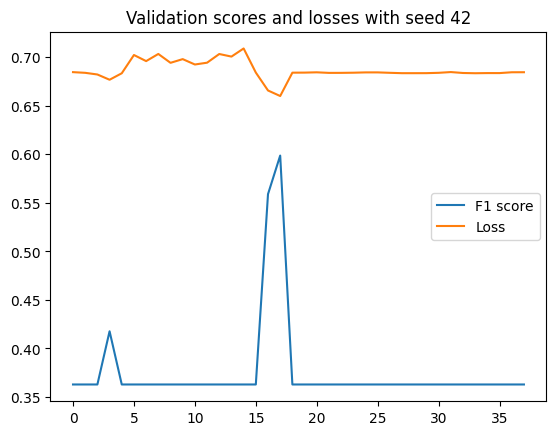


---------------------------------

Training model with seed 43
Epoch [10/150] | Loss on train: 0.6755 | F1 on train: 0.3750 | Loss on validation: 0.6861 | F1 on validation: 0.3629 | LR: 0.001000
Epoch [20/150] | Loss on train: 0.4475 | F1 on train: 0.7923 | Loss on validation: 0.4582 | F1 on validation: 0.7925 | LR: 0.001000
Epoch [30/150] | Loss on train: 0.3444 | F1 on train: 0.8651 | Loss on validation: 0.4695 | F1 on validation: 0.8192 | LR: 0.000100
Epoch [40/150] | Loss on train: 0.2966 | F1 on train: 0.8900 | Loss on validation: 0.5326 | F1 on validation: 0.7957 | LR: 0.000100
Best loss on validation found on epoch 22: 0.4445
F1 score on validation: 0.8131


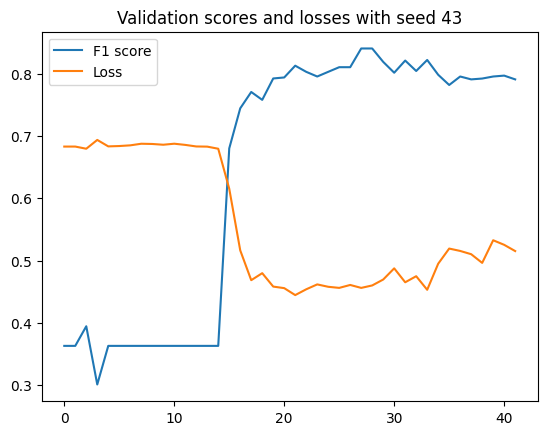


---------------------------------

Training model with seed 44
Epoch [10/150] | Loss on train: 0.6381 | F1 on train: 0.5922 | Loss on validation: 0.6412 | F1 on validation: 0.6220 | LR: 0.001000
Epoch [20/150] | Loss on train: 0.3309 | F1 on train: 0.8551 | Loss on validation: 0.5689 | F1 on validation: 0.8020 | LR: 0.001000
Epoch [30/150] | Loss on train: 0.2202 | F1 on train: 0.9095 | Loss on validation: 0.7261 | F1 on validation: 0.7708 | LR: 0.000100
Best loss on validation found on epoch 15: 0.4747
F1 score on validation: 0.7979


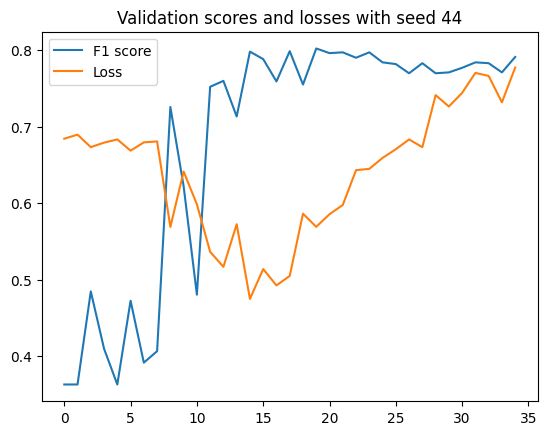


---------------------------------



In [56]:
seeds = [42, 43, 44]
batch_size = 32
baseline_models = {}
train_data = TensorDataset(torch.tensor(np.stack(en_training_df['encoded_tweet'].tolist()), dtype=torch.long), torch.tensor(en_training_df['hard_label_task1'].tolist(), dtype=torch.long))

for seed in seeds:
    print(f'Training model with seed {seed}')
    train_loader = generate_loader(train_data, batch_size, seed)
    model = Baseline(input_size=EMB_DIM, hidden_size=256, output_size=2, dropout=0.3, vocab_size=len(vocab), embedding_matrix=embedding_matrix).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
    model, fscore, loss = train(model, train_loader, criterion, optimizer, scheduler, num_epochs=150, early_stopping_threshold=20, verbose=True, seed=seed)
    baseline_models[seed] = (model, fscore, loss)
    print("\n---------------------------------\n")

The model has good performances on all the three seeds. Now we will save the best model out of the three.

In [57]:
best_baseline = max(baseline_models, key=lambda k: baseline_models[k][1])
print(f'Best model found with seed {best_baseline} with F1 score: {baseline_models[best_baseline][1]:.4f} and loss: {baseline_models[best_baseline][2]:.4f}')
print(f"The mean F1 score of the models is {np.mean([model[1] for model in baseline_models.values()]):.4f}")
print(f"The mean loss of the models is {np.mean([model[2] for model in baseline_models.values()]):.4f}")
print(f"The standard deviation of the F1 scores of the models is {np.std([model[1] for model in baseline_models.values()]):.4f}")

Best model found with seed 43 with F1 score: 0.8131 and loss: 0.4445
The mean F1 score of the models is 0.7366
The mean loss of the models is 0.5264
The standard deviation of the F1 scores of the models is 0.0977


We evaluate `best_model` on the test set.

In [58]:
best_model_state_dict = baseline_models[best_baseline][0]
best_baseline = Baseline(input_size=EMB_DIM, hidden_size=256, output_size=2, dropout=0.3, vocab_size=len(vocab), embedding_matrix=embedding_matrix).cuda()
best_baseline.load_state_dict(best_model_state_dict)

best_baseline.eval()
with torch.no_grad():
    X_test = torch.tensor(np.stack(en_test_df['encoded_tweet'].tolist()), dtype=torch.long).to(best_baseline.device)
    y_test = torch.tensor(en_test_df['hard_label_task1'].tolist(), dtype=torch.long).to(best_baseline.device)
    outputs = best_baseline(X_test)
    predicted_labels = torch.argmax(outputs, dim=1)
    f1 = f1_score(y_true=y_test.cpu().numpy(), y_pred=predicted_labels.cpu().numpy(), average='macro')
    print(f'F1 score on test: {f1:.4f}')

F1 score on test: 0.7746


We print the confusion matrix

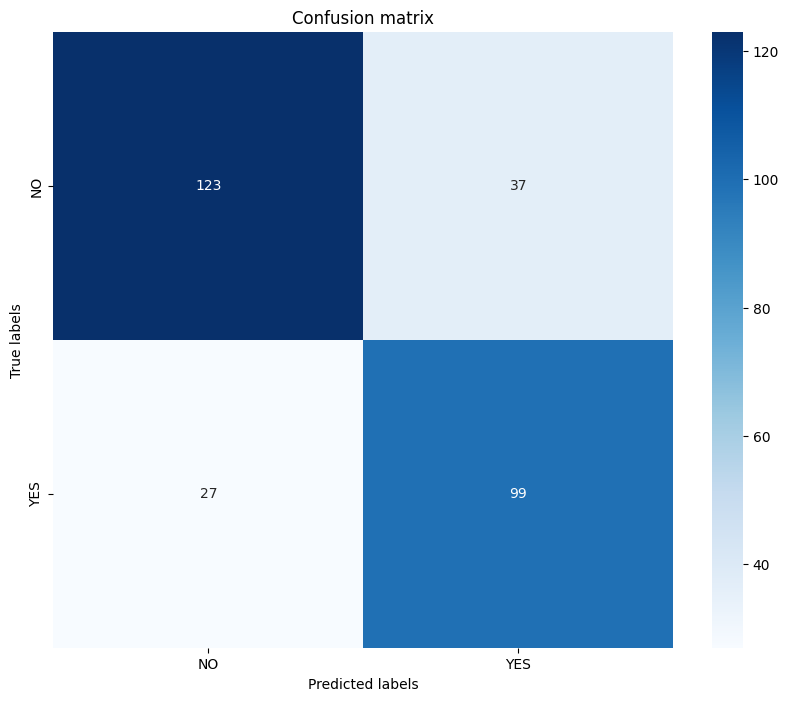

In [59]:
y_test = y_test.cpu().numpy()
predicted_labels = predicted_labels.cpu().numpy()
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

The performances on the test set are slightly lower than the performances on the validation set. We will discuss this in the error analysis section.

Now we look at some missclassified tweets.

In [60]:
examples=0

for i in range(len(y_test)):
    if y_test[i] != predicted_labels[i] and examples< 5:
        print(f"Text: {en_test_df_t['tweet'][i]}")
        print(f"True label: {y_test[i]}")
        print(f"Predicted label: {predicted_labels[i]}")
        print("\n")
        examples+=1

Text: I mean I do but would not it be fun to get gangbange together
True label: 0
Predicted label: 1


Text:    Sex as in gender harassment be what they be infer
True label: 0
Predicted label: 1


Text:   Kabul Islamic Emirate of Afghanistan have announce the end of coeducation in the country cite gender harassmentFemale student will attend university on Monday Wednesday and Saturday while Tuesday Thursday and Sunday be fix for male
True label: 1
Predicted label: 0


Text: appreciate be include along with   on the Uvalde gunman history of cyber gender harassment regrettably unshocke  
True label: 0
Predicted label: 1


Text: the violent antifeminism of a farright movement that see   principally as vessel for breed a new white generation express itself in a fixation on a   return to traditional gender rolesworth every minute to read   take 5 min out of your Sun
True label: 1
Predicted label: 0




C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\2895210212.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Text: {en_test_df_t['tweet'][i]}")


We save the weights for the baseline model.

In [61]:
torch.save(best_baseline.state_dict(), 'models/baseline_model.pth')

We do the same for the `Model1` model.

Training model with seed 42
Epoch [10/150] | Loss on train: 0.6753 | F1 on train: 0.3765 | Loss on validation: 0.6862 | F1 on validation: 0.3629 | LR: 0.001000
Epoch [20/150] | Loss on train: 0.6743 | F1 on train: 0.3759 | Loss on validation: 0.6837 | F1 on validation: 0.3629 | LR: 0.001000
Best loss on validation found on epoch 3: 0.6779
F1 score on validation: 0.4244


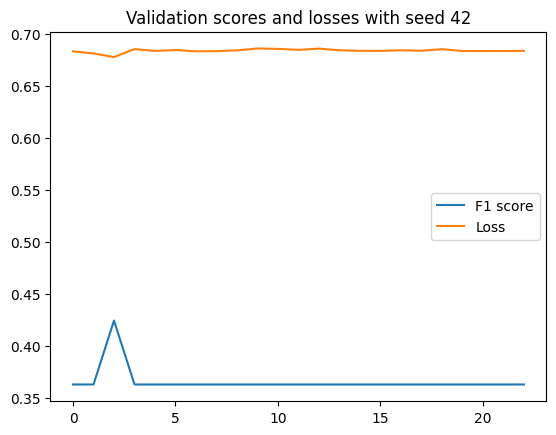


---------------------------------

Training model with seed 43
Epoch [10/150] | Loss on train: 0.4708 | F1 on train: 0.7717 | Loss on validation: 0.4755 | F1 on validation: 0.7671 | LR: 0.001000
Epoch [20/150] | Loss on train: 0.2372 | F1 on train: 0.8988 | Loss on validation: 0.5882 | F1 on validation: 0.8030 | LR: 0.001000
Epoch [30/150] | Loss on train: 0.1627 | F1 on train: 0.9280 | Loss on validation: 0.7654 | F1 on validation: 0.7959 | LR: 0.000100
Best loss on validation found on epoch 12: 0.4704
F1 score on validation: 0.7797


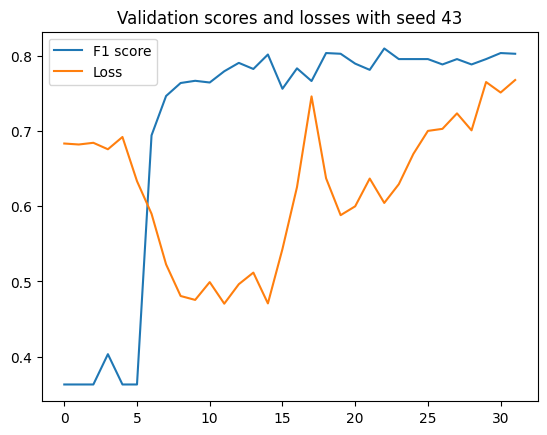


---------------------------------

Training model with seed 44
Epoch [10/150] | Loss on train: 0.6777 | F1 on train: 0.3756 | Loss on validation: 0.6870 | F1 on validation: 0.3629 | LR: 0.001000
Epoch [20/150] | Loss on train: 0.6758 | F1 on train: 0.3902 | Loss on validation: 0.6822 | F1 on validation: 0.3629 | LR: 0.001000
Epoch [30/150] | Loss on train: 0.4945 | F1 on train: 0.7552 | Loss on validation: 0.5394 | F1 on validation: 0.7228 | LR: 0.000100
Epoch [40/150] | Loss on train: 0.4506 | F1 on train: 0.7801 | Loss on validation: 0.5224 | F1 on validation: 0.7641 | LR: 0.000100
Epoch [50/150] | Loss on train: 0.4219 | F1 on train: 0.8091 | Loss on validation: 0.5246 | F1 on validation: 0.7671 | LR: 0.000010
Best loss on validation found on epoch 37: 0.4888
F1 score on validation: 0.7790


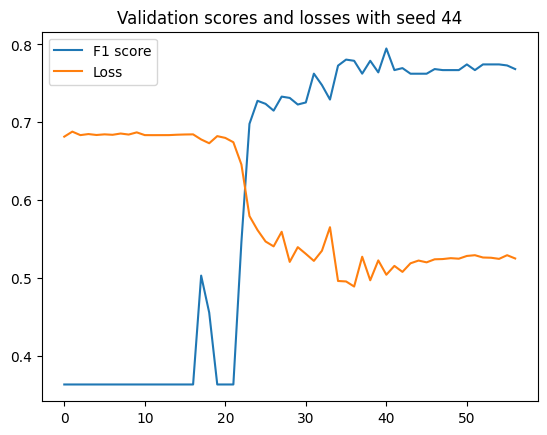


---------------------------------



In [62]:
seeds = [42, 43, 44]
batch_size = 32
model1_models = {}
train_data = TensorDataset(torch.tensor(np.stack(en_training_df['encoded_tweet'].tolist()), dtype=torch.long), torch.tensor(en_training_df['hard_label_task1'].tolist(), dtype=torch.long))

for seed in seeds:
    print(f'Training model with seed {seed}')
    train_loader = generate_loader(train_data, batch_size, seed)
    model = Model1(input_size=EMB_DIM, hidden_size=256, output_size=2, dropout=0.3, vocab_size=len(vocab), embedding_matrix=embedding_matrix).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
    model, fscore, loss = train(model, train_loader, criterion, optimizer, scheduler, num_epochs=150, early_stopping_threshold=20, verbose=True, seed=seed)
    model1_models[seed] = (model, fscore, loss)
    print("\n---------------------------------\n")

We take the best model out of the three seeds.

In [63]:
best_model1 = max(model1_models, key=lambda k: model1_models[k][1])
print(f'Best model found with seed {best_model1} with F1 score: {model1_models[best_model1][1]:.4f} and loss: {model1_models[best_model1][2]:.4f}')
print(f"The mean F1 score of the models is {np.mean([model[1] for model in model1_models.values()]):.4f}")
print(f"The mean loss of the models is {np.mean([model[2] for model in model1_models.values()]):.4f}")
print(f"The standard deviation of the F1 scores of the models is {np.std([model[1] for model in model1_models.values()]):.4f}")

Best model found with seed 43 with F1 score: 0.7797 and loss: 0.4704
The mean F1 score of the models is 0.6611
The mean loss of the models is 0.5457
The standard deviation of the F1 scores of the models is 0.1673


We evaluate `best_model` on the test set.

In [64]:
best_model_state_dict = model1_models[best_model1][0]
best_model1 = Model1(input_size=EMB_DIM, hidden_size=256, output_size=2, dropout=0.3, vocab_size=len(vocab), embedding_matrix=embedding_matrix).cuda()
best_model1.load_state_dict(best_model_state_dict)

best_model1.eval()
with torch.no_grad():
    X_test = torch.tensor(np.stack(en_test_df['encoded_tweet'].tolist()), dtype=torch.long).to(best_model1.device)
    y_test = torch.tensor(en_test_df['hard_label_task1'].tolist(), dtype=torch.long).to(best_model1.device)
    outputs = best_model1(X_test)
    predicted_labels = torch.argmax(outputs, dim=1)
    f1 = f1_score(y_true=y_test.cpu().numpy(), y_pred=predicted_labels.cpu().numpy(), average='macro')
    print(f'F1 score on test: {f1:.4f}')

F1 score on test: 0.7789


We print the confusion matrix.

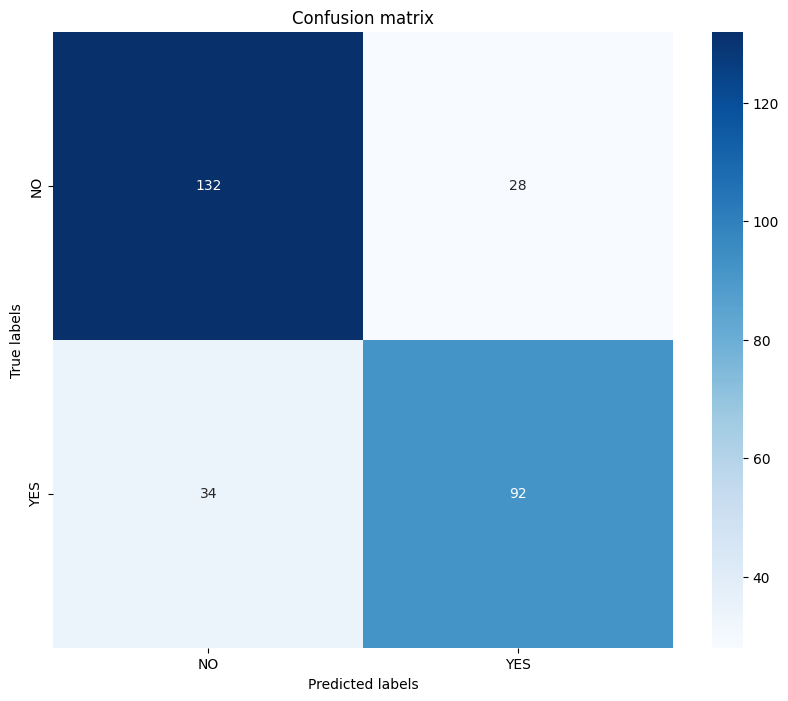

In [65]:
predicted_labels = predicted_labels.cpu().numpy()
y_test = y_test.cpu().numpy()
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

The performances of this model are slightly better than the performances of the `Baseline` model, but just on the validation set. Moreover, the differences are not significant.

The analysis of the results will be described in the Error Analysis section.

Now we look at some examples of missclassified tweets.

In [66]:
examples=0

for i in range(len(y_test)):
    if y_test[i] != predicted_labels[i] and examples< 5:
        print(f"Text: {en_test_df_t['tweet'][i]}")
        print(f"True label: {y_test[i]}")
        print(f"Predicted label: {predicted_labels[i]}")
        print("\n")
        examples+=1

Text:    Sex as in gender harassment be what they be infer
True label: 0
Predicted label: 1


Text:   Kabul Islamic Emirate of Afghanistan have announce the end of coeducation in the country cite gender harassmentFemale student will attend university on Monday Wednesday and Saturday while Tuesday Thursday and Sunday be fix for male
True label: 1
Predicted label: 0


Text: appreciate be include along with   on the Uvalde gunman history of cyber gender harassment regrettably unshocke  
True label: 0
Predicted label: 1


Text: the violent antifeminism of a farright movement that see   principally as vessel for breed a new white generation express itself in a fixation on a   return to traditional gender rolesworth every minute to read   take 5 min out of your Sun
True label: 1
Predicted label: 0


Text: my baby call I mommy Sha for the first time today twice Yall do not understand how hype that make I Baby girl have autism and get she to talk without be prompt have be a challenge she s com

C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\2895210212.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Text: {en_test_df_t['tweet'][i]}")


We save the weights for the Model1.

In [67]:
torch.save(best_baseline.state_dict(), 'models/model1.pth')

---

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




We Download the model and the tokenizer from huggingface.

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

login()

#MAPPING THE OUTPUTS
id2label = {0: "NO", 1: "YES"}
label2id = {"NO": 0, "YES": 1}

task='hate'
model_name = f"cardiffnlp/twitter-roberta-base-{task}"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(model_name)

We convert the pandas dataframes to huggingface datasets so that they can be used in the huggingface roBERTa model.

In [69]:
en_train_df_pt = Dataset.from_pandas(en_train_df_t)
en_val_df_pt = Dataset.from_pandas(en_val_df_t)
en_test_df_pt = Dataset.from_pandas(en_test_df_t)

We take the cleaned data and we use the tokenizer we just downloaded for the model to elaborate the data. 

In [70]:
def tokenization(example):
    return tokenizer(example["text"])


en_train_df_pt = en_train_df_pt.map(lambda examples: tokenizer(examples["tweet"]), batched=True)
en_val_df_pt = en_val_df_pt.map(lambda examples: tokenizer(examples["tweet"]), batched=True)
en_test_df_pt = en_test_df_pt.map(lambda examples: tokenizer(examples["tweet"]), batched=True)

en_train_df_pt = en_train_df_pt.rename_column("hard_label_task1", "label")
en_val_df_pt = en_val_df_pt.rename_column("hard_label_task1", "label")
en_test_df_pt = en_test_df_pt.rename_column("hard_label_task1", "label")

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

We define the metrics for the training of the model.

In [15]:
f1_metric = evaluate.load('f1')

def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)
    
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    return {**f1}
    

We define the arguments for the trainer.

In [72]:
training_args = TrainingArguments(
    output_dir="test_dir",                 # where to save model
    learning_rate=1e-6,
    lr_scheduler_type='linear',            # learning rate scheduler             
    per_device_train_batch_size=32,        # accelerate defines distributed training
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",           # when to report evaluation metrics/losses
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                       # disabling wandb (default)
)

c:\Users\nanni\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We train the model with the tokenized tweets.

In [73]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=en_train_df_pt,
    eval_dataset=en_val_df_pt,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\2189201491.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [74]:
trainer.train()

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.4389397203922272, 'eval_f1': 0.7876344086021505, 'eval_runtime': 0.6254, 'eval_samples_per_second': 252.647, 'eval_steps_per_second': 7.995, 'epoch': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.4206131100654602, 'eval_f1': 0.8222722159730034, 'eval_runtime': 0.6099, 'eval_samples_per_second': 259.046, 'eval_steps_per_second': 8.198, 'epoch': 2.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.4018658399581909, 'eval_f1': 0.8431761786600496, 'eval_runtime': 0.5506, 'eval_samples_per_second': 286.961, 'eval_steps_per_second': 9.081, 'epoch': 3.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.4033655524253845, 'eval_f1': 0.8222722159730034, 'eval_runtime': 0.6087, 'eval_samples_per_second': 259.573, 'eval_steps_per_second': 8.214, 'epoch': 4.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.400311678647995, 'eval_f1': 0.8222722159730034, 'eval_runtime': 0.5497, 'eval_samples_per_second': 287.422, 'eval_steps_per_second': 9.096, 'epoch': 5.0}
{'loss': 0.4181, 'grad_norm': 9.841779708862305, 'learning_rate': 4.444444444444444e-07, 'epoch': 5.56}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.3986898362636566, 'eval_f1': 0.8222722159730034, 'eval_runtime': 0.8979, 'eval_samples_per_second': 175.967, 'eval_steps_per_second': 5.569, 'epoch': 6.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.39706507325172424, 'eval_f1': 0.8284043441938178, 'eval_runtime': 0.5397, 'eval_samples_per_second': 292.741, 'eval_steps_per_second': 9.264, 'epoch': 7.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.3933354616165161, 'eval_f1': 0.8284043441938178, 'eval_runtime': 0.3504, 'eval_samples_per_second': 450.885, 'eval_steps_per_second': 14.269, 'epoch': 8.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.39467743039131165, 'eval_f1': 0.8284043441938178, 'eval_runtime': 0.3455, 'eval_samples_per_second': 457.31, 'eval_steps_per_second': 14.472, 'epoch': 9.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.3937326967716217, 'eval_f1': 0.8284043441938178, 'eval_runtime': 0.3331, 'eval_samples_per_second': 474.318, 'eval_steps_per_second': 15.01, 'epoch': 10.0}
{'train_runtime': 324.642, 'train_samples_per_second': 88.405, 'train_steps_per_second': 2.772, 'train_loss': 0.39411829630533857, 'epoch': 10.0}


TrainOutput(global_step=900, training_loss=0.39411829630533857, metrics={'train_runtime': 324.642, 'train_samples_per_second': 88.405, 'train_steps_per_second': 2.772, 'total_flos': 949985076483600.0, 'train_loss': 0.39411829630533857, 'epoch': 10.0})

We set the model in the testing mode, then we proceced to predict the labels.

In [75]:
model.eval()

output = trainer.predict(en_test_df_pt)

  0%|          | 0/9 [00:00<?, ?it/s]

We now proceed to show the output metrics for our tweets.

In [76]:
output.metrics

{'test_loss': 0.39735403656959534,
 'test_f1': 0.8376043055349824,
 'test_runtime': 0.5629,
 'test_samples_per_second': 508.105,
 'test_steps_per_second': 15.989}

We save the weights of the model.

In [77]:
trainer.save_model("./models/transformer.pth")

We print the confusion matrix.

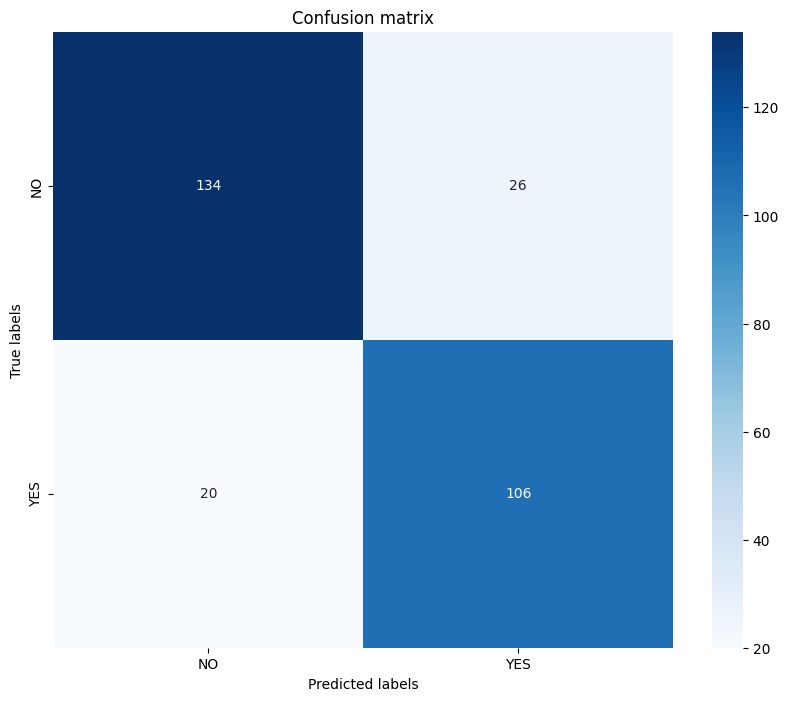

In [78]:
y_test = en_test_df_pt['label']
predicted_labels = np.argmax(output.predictions, axis=-1)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

As we can see the results are way better than the previous models. This is because we are using a transformer architecture instead of an LSTM one. The transformer is able to capture the context of the words in a better way than the LSTM, which is why it performs better on this task.

Now we observe some exemples of missclassified tweets, to understand why the model failed to predict the correct label.

In [79]:
examples=0

for i in range(len(y_test)):
    if y_test[i] != predicted_labels[i] and examples< 5:
        print(f"Text: {en_test_df_t['tweet'][i]}")
        print(f"True label: {y_test[i]}")
        print(f"Predicted label: {predicted_labels[i]}")
        print("\n")
        examples+=1

Text: Suika get gangbange to death
True label: 1
Predicted label: 0


Text:    Sex as in gender harassment be what they be infer
True label: 0
Predicted label: 1


Text:    ah look Gender role be back too the do not believe their own lie
True label: 1
Predicted label: 0


Text: isa hot girl summer now pop you all shit
True label: 0
Predicted label: 1


Text:   how do we reach a point where blonk be have the audacity to talk about yoongis rap do you all see who you Stan   be you all ok   your girl can not write can not deliver can not come close to btss lyricism tf be you all get brave for   fashion deal
True label: 0
Predicted label: 1




C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\2895210212.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Text: {en_test_df_t['tweet'][i]}")


Further analysis will be discussed in the Error Analysis section.

---

# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



### Single-layer LSTM model

The single-layer LSTM model has overall good performances on both the validation and test sets. The model is able to capture the context of the tweets and predict the correct label. In particular, the difference of performances between the validation and test sets is given by the fact that we select as "best model" the one with the lowest loss on the validation set.

By looking at the confusion matrix, we notice that the best model (seed 44) tends to detect false negatives more than false positives. If we look at the missclassified tweets, we can see that the model struggles with tweets that probably contained special elements like hashtag and emojis, which have been removed (due to the preprocessing step). This is a common issue in text classification tasks, as the model is not able to capture the meaning of the tweets without these elements.

### Double-layer LSTM model

The double-layer LSTM model (seed 44) has slightly better performances on the validation set than the single-layer LSTM model, but the differences are not significant. The model is able to capture the context of the tweets and predict the correct label. The performances on the test set are slightly worse, but this is probably due to random factors. In fact, the mean of the F1 for all the seeds on the validation is 0.79 (higher than the mean of the F1 of the baseline model, which is 0.75), with also a lower standard deviation, indicating that the model is more stable. We can see that the model has also a higher loss on the validation set, which is probably due to the fact that the model is more complex and needs more epochs to converge (also considering that we are already using a very low learning rate).

By looking at the confusion matrix, we notice that the model tends to detect false positives more than false negatives. In general, all the problems that we have seen with the single-layer LSTM model are also present in the double-layer LSTM model. 

To address these issues, we can try to use a more complex model, like a transformer, which is able to capture the context of the tweets in a better way. Moreover, we can try to use a more complex preprocessing step, which is able to capture the meaning of the tweets without removing special elements like hashtags and emojis. Another solution could be to use a more complex similarity function to find the most similar word in the GloVe embeddings for the OOV tokens.

### Transformer model

The transformer model has the best performances on both the validation and test sets. The model is able to capture the context of the tweets and predict the correct label. The performances on the test set are significantly better than the performances of the LSTM models. This is due to the fact that the transformer is able to capture the context of the words in a better way than the LSTM, which is why it performs better on this task. Another reason for the better performances is that the transformer has been pre-trained on a large corpus of tweets for hate speech detection, so it is able to capture the context of the tweets in a better way.

By looking at the confusion matrix, we notice that the model tends to detect false negatives more than false positives, similar to the single-layer LSTM model. In general, all the problems that we have seen with the LSTM models are also present in the transformer model (e.g. the model struggles with tweets that probably contained special elements like hashtag and emojis, which have been removed).

In some cases, a tweet referencing a specific event or meme might be misinterpreted if the model lacks knowledge about that context. In these cases, the knowledge base of the LLM is crucial to understand the meaning of the tweet. To address these issues in future work, we could implement a better approach to handle data cleaning (specifically for hashtags handling) and we could apply data augmentation to increase the diversity and size of the training dataset.

---------

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

---------

## Spanish (bonus points)

We apply the same pipeline to the Spanish tweets. First of all, we load the Spanish data from the original dataframes.

In [16]:
es_test_df = test_df[test_df['lang'] == 'es']
es_training_df = training_df[training_df['lang'] == 'es']
es_validation_df = validation_df[validation_df['lang'] == 'es']

In [17]:
print('Spanish test data shape:', es_test_df.shape)
print('Spanish training data shape:', es_training_df.shape)
print('Spanish validation data shape:', es_validation_df.shape)

Spanish test data shape: (0, 3)
Spanish training data shape: (3194, 3)
Spanish validation data shape: (490, 3)


In [18]:
es_test_df_t = es_test_df.copy()
es_train_df_t = es_training_df.copy()
es_val_df_t = es_validation_df.copy()

We can see that the Spanish tweets are not present in the test set. Thus, we'll use just the validation set to evaluate the models.

We proceed with the pipeline as in the main task.

In [83]:
es_training_df['tweet'] = es_training_df.apply(lambda row: process_text(row['tweet'], 'es'), axis=1)
print("Training data cleaned.")

es_validation_df['tweet'] = es_validation_df.apply(lambda row: process_text(row['tweet'], 'es'), axis=1)
print("Validation data cleaned.")

C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\2574034688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_training_df['tweet'] = es_training_df.apply(lambda row: process_text(row['tweet'], 'es'), axis=1)


Training data cleaned.
Validation data cleaned.


C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\2574034688.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_validation_df['tweet'] = es_validation_df.apply(lambda row: process_text(row['tweet'], 'es'), axis=1)


We first load the GloVe embeddings for the Spanish language.

In [84]:
es_training_df['tweet'] = es_training_df['tweet'].apply(lambda x: x.split())
all_tokens = np.array([token.lower() for tweet in es_training_df['tweet'] for token in tweet])
not_embedded = set(all_tokens[~np.isin(all_tokens, list(token_to_emb.keys()))])

print('Number of tokens not embedded:', len(not_embedded))

C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\3863687398.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_training_df['tweet'] = es_training_df['tweet'].apply(lambda x: x.split())


Number of tokens not embedded: 2842


Now we apply the same preprocess pipeline for the Spanish OOV tokens.

In [86]:
OOV_token_to_emb = dict()
np.random.seed(42)

OOV_token_to_emb = dict()
for OOV_token in not_embedded:
    closest_word, similarity = get_adjusted_embedding(OOV_token, token_to_emb, OOV_token_to_emb)

In [87]:
np.random.seed(42)
unk_emb = np.random.rand(EMB_DIM)
pad_emb = np.zeros(EMB_DIM)

In [88]:
token_map = token_to_emb.copy()
token_map.update(OOV_token_to_emb)
token_map['<unk>'] = unk_emb
token_map['<pad>'] = pad_emb

print('Number of tokens in the vocabulary:', len(token_map))

Number of tokens in the vocabulary: 1196357


In [89]:
%%capture

es_training_df['tweet'].apply(process_tweet, args=(token_map,))

Before training the models, we need to define the input shape for the Spanish tweets. We can use the maximum length of the Spanish tweets in the training set and then pad the sequences.

In [90]:
max_tweet_length = max(es_training_df['tweet'].apply(len))
print(f"Max tweet length: {max_tweet_length}")

Max tweet length: 60


In [91]:
es_training_df['tweet'] = es_training_df['tweet'].apply(lambda x: pad_sequence(x, max_tweet_length))

es_test_df['tweet'] = es_test_df['tweet'].apply(lambda x: x.split())
es_test_df['tweet'] = es_test_df['tweet'].apply(lambda x: pad_sequence(x, max_tweet_length))

es_validation_df['tweet'] = es_validation_df['tweet'].apply(lambda x: x.split())
es_validation_df['tweet'] = es_validation_df['tweet'].apply(lambda x: pad_sequence(x, max_tweet_length))

C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\2621354546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_training_df['tweet'] = es_training_df['tweet'].apply(lambda x: pad_sequence(x, max_tweet_length))
C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\2621354546.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_validation_df['tweet'] = es_validation_df['tweet'].apply(lambda x: x.split())
C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\2621354546.py:7: SettingWithCopyWarning: 
A value is t

Since we added new OOV tokens to the vocabulary, we need to update the embeddings matrix.

In [92]:
vocab = {word.lower(): idx for idx, word in enumerate(token_map.keys(), start=1)}
vocab["<pad>"] = 0
embedding_matrix = np.zeros((len(vocab)+1, EMB_DIM))
for word, idx in vocab.items():
    if word in token_map and len(token_map[word]) == EMB_DIM:
        embedding_matrix[idx] = token_map[word]

In [93]:
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32).cuda() if torch.cuda.is_available() else torch.tensor(embedding_matrix, dtype=torch.float32)

Now we create another column in the Spanish dataframes, mapping each token to its corresponding index in the embedding matrix.

In [94]:
es_training_df['encoded_tweet'] = es_training_df['tweet'].apply(lambda x: torch.tensor([vocab.get(token.lower()) for token in x], dtype=torch.long))
es_validation_df['encoded_tweet'] = es_validation_df['tweet'].apply(lambda x: torch.tensor([vocab.get(token.lower(), vocab['<unk>']) for token in x], dtype=torch.long))

C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\1356117340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_training_df['encoded_tweet'] = es_training_df['tweet'].apply(lambda x: torch.tensor([vocab.get(token.lower()) for token in x], dtype=torch.long))
C:\Users\nanni\AppData\Local\Temp\ipykernel_22440\1356117340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_validation_df['encoded_tweet'] = es_validation_df['tweet'].apply(lambda x: torch.tensor([vocab.get(token.lower(), vocab['<unk>']) for 

Training and evaluation for the Spanish tweets is the same as for the English tweets. We start by training the `Baseline` model.

Training model with seed 42
Epoch [10/1000] | Loss on train: 0.6928 | F1 on train: 0.3530 | Loss on validation: 0.6915 | F1 on validation: 0.3629 | LR: 0.001000
Epoch [20/1000] | Loss on train: 0.6672 | F1 on train: 0.5050 | Loss on validation: 0.7181 | F1 on validation: 0.4925 | LR: 0.001000
Best loss on validation found on epoch 5: 0.6878
F1 score on validation: 0.3629


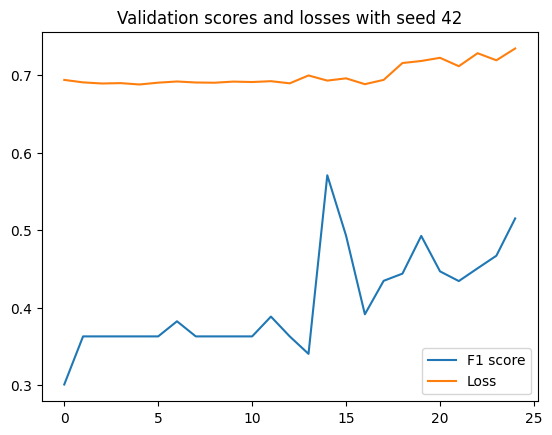


---------------------------------

Training model with seed 43
Epoch [10/1000] | Loss on train: 0.6964 | F1 on train: 0.3934 | Loss on validation: 0.6896 | F1 on validation: 0.3629 | LR: 0.001000
Epoch [20/1000] | Loss on train: 0.6934 | F1 on train: 0.3651 | Loss on validation: 0.6951 | F1 on validation: 0.3009 | LR: 0.001000
Best loss on validation found on epoch 8: 0.6843
F1 score on validation: 0.3629


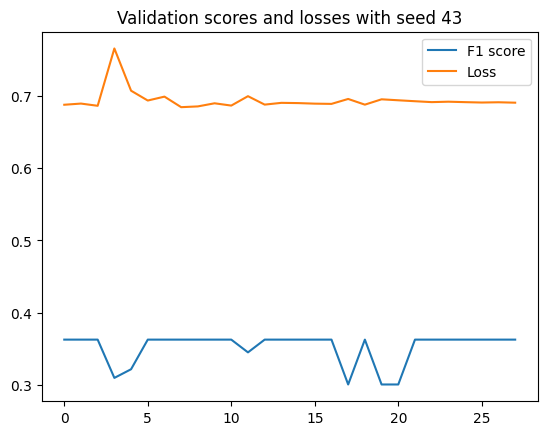


---------------------------------

Training model with seed 44
Epoch [10/1000] | Loss on train: 0.6911 | F1 on train: 0.3784 | Loss on validation: 0.6896 | F1 on validation: 0.3761 | LR: 0.001000
Epoch [20/1000] | Loss on train: 0.6715 | F1 on train: 0.5089 | Loss on validation: 0.6797 | F1 on validation: 0.5059 | LR: 0.001000
Epoch [30/1000] | Loss on train: 0.6454 | F1 on train: 0.6545 | Loss on validation: 0.7504 | F1 on validation: 0.4376 | LR: 0.000100
Epoch [40/1000] | Loss on train: 0.6173 | F1 on train: 0.6713 | Loss on validation: 0.6487 | F1 on validation: 0.6508 | LR: 0.000100
Epoch [50/1000] | Loss on train: 0.6138 | F1 on train: 0.6660 | Loss on validation: 0.6515 | F1 on validation: 0.6453 | LR: 0.000010
Best loss on validation found on epoch 39: 0.6210
F1 score on validation: 0.6832


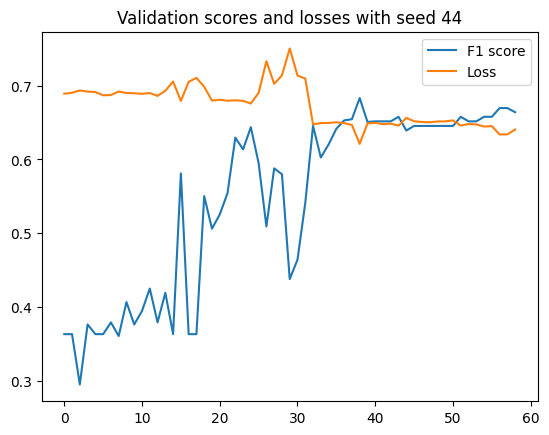


---------------------------------



In [ ]:
seeds = [42, 43, 44]
batch_size = 32
baseline_models = {}
train_data = TensorDataset(torch.tensor(np.stack(es_training_df['encoded_tweet'].tolist()), dtype=torch.long), torch.tensor(es_training_df['hard_label_task1'].tolist(), dtype=torch.long))

for seed in seeds:
    print(f'Training model with seed {seed}')
    train_loader = generate_loader(train_data, batch_size, seed)
    model = Baseline(input_size=EMB_DIM, hidden_size=256, output_size=2, dropout=0.3, vocab_size=len(vocab), embedding_matrix=embedding_matrix).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
    model, fscore, loss = train(model, train_loader, criterion, optimizer, scheduler, num_epochs=150, early_stopping_threshold=20, verbose=True, seed=seed)
    baseline_models[seed] = (model, fscore, loss)
    print("\n---------------------------------\n")

In [96]:
best_baseline = max(baseline_models, key=lambda k: baseline_models[k][1])
print(f'Best model found with seed {best_baseline} with F1 score: {baseline_models[best_baseline][1]:.4f} and loss: {baseline_models[best_baseline][2]:.4f}')
print(f"The mean F1 score of the models is {np.mean([model[1] for model in baseline_models.values()]):.4f}")
print(f"The mean loss of the models is {np.mean([model[2] for model in baseline_models.values()]):.4f}")
print(f"The standard deviation of the F1 scores of the models is {np.std([model[1] for model in baseline_models.values()]):.4f}")

Best model found with seed 44 with F1 score: 0.6832 and loss: 0.6210
The mean F1 score of the models is 0.4697
The mean loss of the models is 0.6644
The standard deviation of the F1 scores of the models is 0.1510


In [97]:
best_model_state_dict = baseline_models[best_baseline][0]
best_baseline = Baseline(input_size=EMB_DIM, hidden_size=256, output_size=2, dropout=0.3, vocab_size=len(vocab), embedding_matrix=embedding_matrix).cuda()
best_baseline.load_state_dict(best_model_state_dict)

best_baseline.eval()
with torch.no_grad():
    X_val = torch.tensor(np.stack(es_validation_df['encoded_tweet'].tolist()), dtype=torch.long).to(best_baseline.device)
    y_val = torch.tensor(es_validation_df['hard_label_task1'].tolist(), dtype=torch.long).to(best_baseline.device)
    outputs = best_baseline(X_val)
    predicted_labels = torch.argmax(outputs, dim=1)
    f1 = f1_score(y_true=y_val.cpu().numpy(), y_pred=predicted_labels.cpu().numpy(), average='macro')
    print(f'F1 score on test: {f1:.4f}')

F1 score on test: 0.6606


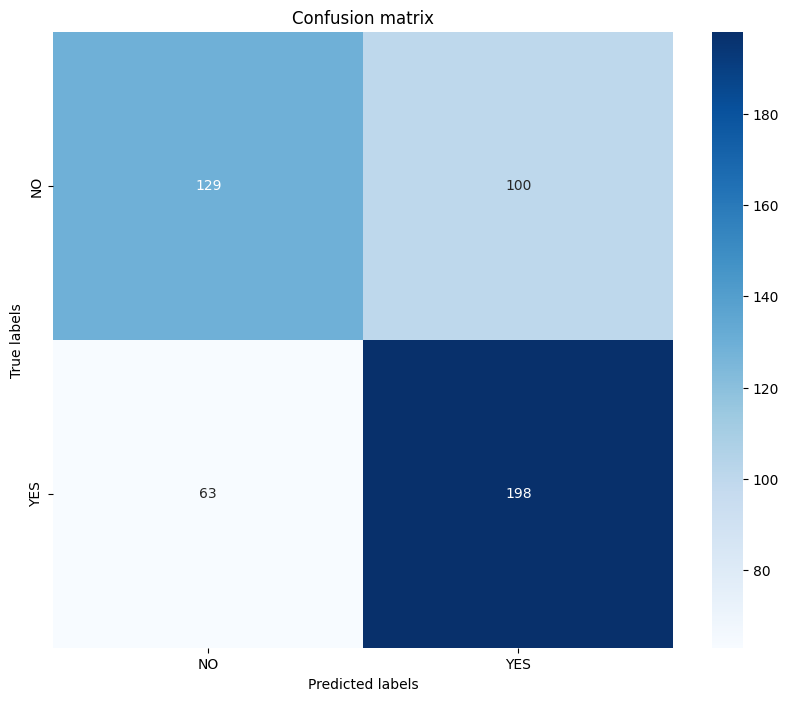

In [98]:
y_val = y_val.cpu().numpy()
predicted_labels = predicted_labels.cpu().numpy()
conf_matrix = confusion_matrix(y_true=y_val, y_pred=predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

Saving the best model.

In [100]:
torch.save(best_baseline.state_dict(), 'models/baseline_model_es.pth')

We then train the `Model1` model.

Training model with seed 42
Epoch [10/150] | Loss on train: 0.6925 | F1 on train: 0.3676 | Loss on validation: 0.6898 | F1 on validation: 0.3629 | LR: 0.001000
Epoch [20/150] | Loss on train: 0.6819 | F1 on train: 0.4796 | Loss on validation: 0.6434 | F1 on validation: 0.5926 | LR: 0.001000
Epoch [30/150] | Loss on train: 0.6418 | F1 on train: 0.6146 | Loss on validation: 0.6260 | F1 on validation: 0.6642 | LR: 0.000100
Epoch [40/150] | Loss on train: 0.6170 | F1 on train: 0.6488 | Loss on validation: 0.6244 | F1 on validation: 0.6459 | LR: 0.000100
Epoch [50/150] | Loss on train: 0.5864 | F1 on train: 0.6963 | Loss on validation: 0.6359 | F1 on validation: 0.6289 | LR: 0.000010
Epoch [60/150] | Loss on train: 0.5729 | F1 on train: 0.7003 | Loss on validation: 0.6446 | F1 on validation: 0.6078 | LR: 0.000010
Best loss on validation found on epoch 42: 0.6222
F1 score on validation: 0.6514


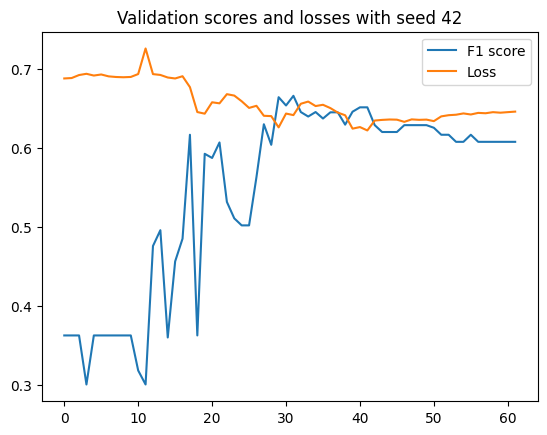


---------------------------------

Training model with seed 43
Epoch [10/150] | Loss on train: 0.6955 | F1 on train: 0.4180 | Loss on validation: 0.6605 | F1 on validation: 0.5949 | LR: 0.001000
Epoch [20/150] | Loss on train: 0.5516 | F1 on train: 0.7206 | Loss on validation: 0.6957 | F1 on validation: 0.5506 | LR: 0.001000
Epoch [30/150] | Loss on train: 0.4458 | F1 on train: 0.7949 | Loss on validation: 0.8831 | F1 on validation: 0.4530 | LR: 0.000100
Best loss on validation found on epoch 17: 0.6420
F1 score on validation: 0.5805


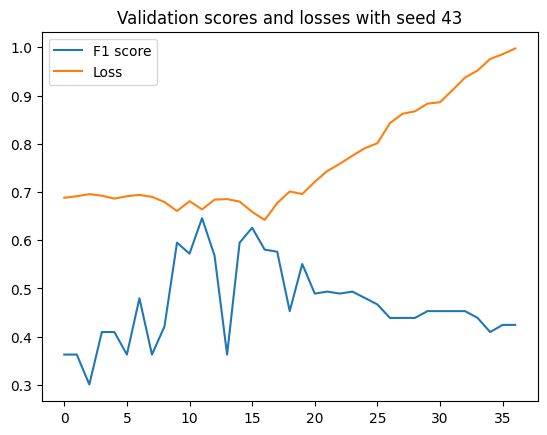


---------------------------------

Training model with seed 44
Epoch [10/150] | Loss on train: 0.6929 | F1 on train: 0.3532 | Loss on validation: 0.6917 | F1 on validation: 0.3761 | LR: 0.001000
Epoch [20/150] | Loss on train: 0.6929 | F1 on train: 0.3364 | Loss on validation: 0.6903 | F1 on validation: 0.3629 | LR: 0.001000
Epoch [30/150] | Loss on train: 0.6928 | F1 on train: 0.3365 | Loss on validation: 0.6904 | F1 on validation: 0.3629 | LR: 0.000100
Best loss on validation found on epoch 16: 0.6897
F1 score on validation: 0.3629


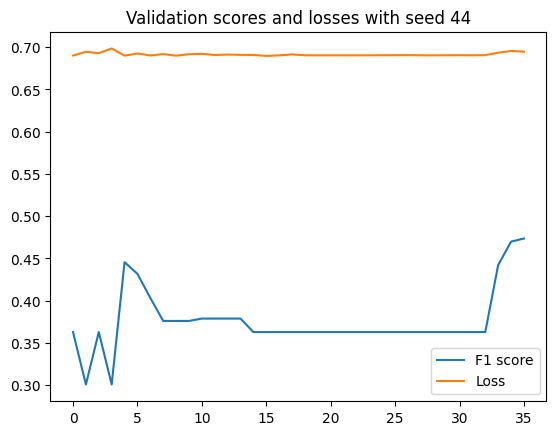


---------------------------------



In [102]:
seeds = [42, 43, 44]
batch_size = 32
model1_models = {}
train_data = TensorDataset(torch.tensor(np.stack(es_training_df['encoded_tweet'].tolist()), dtype=torch.long), torch.tensor(es_training_df['hard_label_task1'].tolist(), dtype=torch.long))

for seed in seeds:
    print(f'Training model with seed {seed}')
    train_loader = generate_loader(train_data, batch_size, seed)
    model = Model1(input_size=EMB_DIM, hidden_size=256, output_size=2, dropout=0.3, vocab_size=len(vocab), embedding_matrix=embedding_matrix).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
    model, fscore, loss = train(model, train_loader, criterion, optimizer, scheduler, num_epochs=150, early_stopping_threshold=20, verbose=True, seed=seed)
    model1_models[seed] = (model, fscore, loss)
    print("\n---------------------------------\n")

In [103]:
best_model1 = max(model1_models, key=lambda k: model1_models[k][1])
print(f'Best model found with seed {best_model1} with F1 score: {model1_models[best_model1][1]:.4f} and loss: {model1_models[best_model1][2]:.4f}')
print(f"The mean F1 score of the models is {np.mean([model[1] for model in model1_models.values()]):.4f}")
print(f"The mean loss of the models is {np.mean([model[2] for model in model1_models.values()]):.4f}")
print(f"The standard deviation of the F1 scores of the models is {np.std([model[1] for model in model1_models.values()]):.4f}")

Best model found with seed 42 with F1 score: 0.6514 and loss: 0.6222
The mean F1 score of the models is 0.5316
The mean loss of the models is 0.6513
The standard deviation of the F1 scores of the models is 0.1228


In [104]:
best_model_state_dict = model1_models[best_model1][0]
best_model1 = Model1(input_size=EMB_DIM, hidden_size=256, output_size=2, dropout=0.3, vocab_size=len(vocab), embedding_matrix=embedding_matrix).cuda()
best_model1.load_state_dict(best_model_state_dict)

best_model1.eval()
with torch.no_grad():
    X_val = torch.tensor(np.stack(es_validation_df['encoded_tweet'].tolist()), dtype=torch.long).to(best_model1.device)
    y_val = torch.tensor(es_validation_df['hard_label_task1'].tolist(), dtype=torch.long).to(best_model1.device)
    outputs = best_model1(X_val)
    predicted_labels = torch.argmax(outputs, dim=1)
    f1 = f1_score(y_true=y_val.cpu().numpy(), y_pred=predicted_labels.cpu().numpy(), average='macro')
    print(f'F1 score on test: {f1:.4f}')

F1 score on test: 0.6755


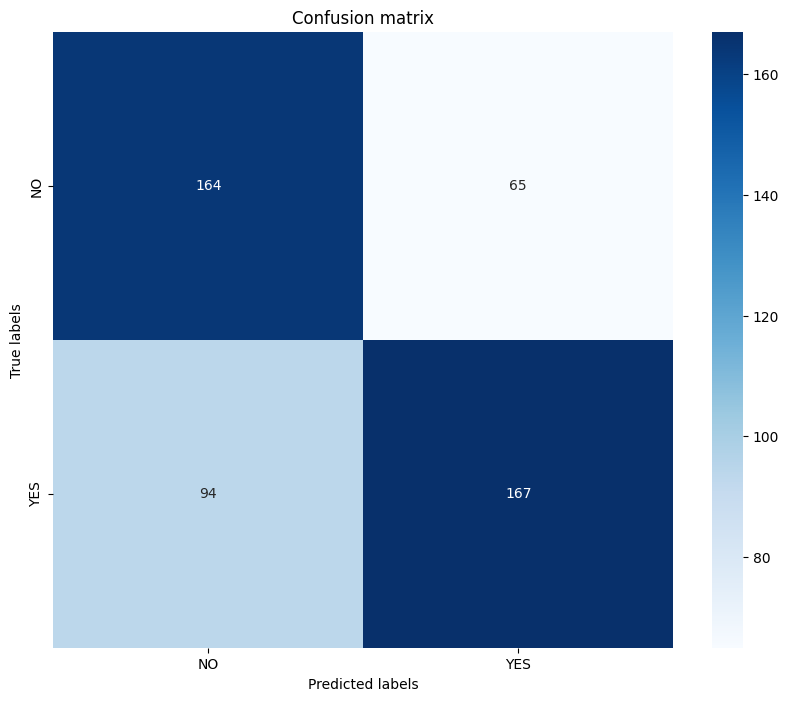

In [105]:
y_val = y_val.cpu().numpy()
predicted_labels = predicted_labels.cpu().numpy()
conf_matrix = confusion_matrix(y_true=y_val, y_pred=predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

We save the best model.

In [106]:
torch.save(best_model1.state_dict(), 'models/model1_es.pth')

We now train the Transformer model for Spanish tweets.

We Download the model and the tokenizer from huggingface.

In [19]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

#MAPPING THE OUTPUTS
id2label = {0: "NO", 1: "YES"}
label2id = {"NO": 0, "YES": 1}


model_name = "cardiffnlp/twitter-roberta-base-hate"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(model_name)

We convert the pandas dataframes to huggingface datasets so that they can be used in the huggingface roBERTa model.

In [20]:
es_train_df_pt = Dataset.from_pandas(es_train_df_t)
es_val_df_pt = Dataset.from_pandas(es_val_df_t)
es_test_df_pt = Dataset.from_pandas(es_test_df_t)

We take the cleaned data and we use the tokenizer we just downloaded for the model to elaborate the data. 

In [21]:
def tokenization(example):
    return tokenizer(example["text"])


es_train_df_pt = es_train_df_pt.map(lambda examples: tokenizer(examples["tweet"]), batched=True)
es_val_df_pt = es_val_df_pt.map(lambda examples: tokenizer(examples["tweet"]), batched=True)
es_test_df_pt = es_test_df_pt.map(lambda examples: tokenizer(examples["tweet"]), batched=True)

es_train_df_pt = es_train_df_pt.rename_column("hard_label_task1", "label")
es_val_df_pt = es_val_df_pt.rename_column("hard_label_task1", "label")
es_test_df_pt = es_test_df_pt.rename_column("hard_label_task1", "label")

Map:   0%|          | 0/3194 [00:00<?, ? examples/s]

Map:   0%|          | 0/490 [00:00<?, ? examples/s]

We define the arguments for the trainer.

In [22]:
training_args = TrainingArguments(
    output_dir="test_dir_es",                 # where to save model
    learning_rate=1e-6,
    lr_scheduler_type='linear',            # learning rate scheduler             
    per_device_train_batch_size=32,        # accelerate defines distributed training
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",           # when to report evaluation metrics/losses
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                       # disabling wandb (default)
)

c:\Users\nanni\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We train the model with the tokenized tweets.

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=es_train_df_pt,
    eval_dataset=es_val_df_pt,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

C:\Users\nanni\AppData\Local\Temp\ipykernel_8644\4057451773.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.6118925213813782, 'eval_f1': 0.6720708059361876, 'eval_runtime': 11.4855, 'eval_samples_per_second': 42.662, 'eval_steps_per_second': 1.393, 'epoch': 1.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5681313276290894, 'eval_f1': 0.7017227864778772, 'eval_runtime': 11.5747, 'eval_samples_per_second': 42.334, 'eval_steps_per_second': 1.382, 'epoch': 2.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5470531582832336, 'eval_f1': 0.7195566714430737, 'eval_runtime': 11.576, 'eval_samples_per_second': 42.329, 'eval_steps_per_second': 1.382, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5346266031265259, 'eval_f1': 0.7323308772324872, 'eval_runtime': 34.8162, 'eval_samples_per_second': 14.074, 'eval_steps_per_second': 0.46, 'epoch': 4.0}
{'loss': 0.6071, 'grad_norm': 8.55703353881836, 'learning_rate': 5e-07, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5278504490852356, 'eval_f1': 0.7342511472674176, 'eval_runtime': 34.5586, 'eval_samples_per_second': 14.179, 'eval_steps_per_second': 0.463, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5231592059135437, 'eval_f1': 0.7405732152162585, 'eval_runtime': 35.0409, 'eval_samples_per_second': 13.984, 'eval_steps_per_second': 0.457, 'epoch': 6.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5183007121086121, 'eval_f1': 0.7423377403846154, 'eval_runtime': 32.5912, 'eval_samples_per_second': 15.035, 'eval_steps_per_second': 0.491, 'epoch': 7.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5169339179992676, 'eval_f1': 0.7425096756973175, 'eval_runtime': 32.6612, 'eval_samples_per_second': 15.002, 'eval_steps_per_second': 0.49, 'epoch': 8.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5156663656234741, 'eval_f1': 0.746596823702122, 'eval_runtime': 32.8986, 'eval_samples_per_second': 14.894, 'eval_steps_per_second': 0.486, 'epoch': 9.0}
{'loss': 0.5051, 'grad_norm': 20.843965530395508, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5156096816062927, 'eval_f1': 0.746596823702122, 'eval_runtime': 32.5845, 'eval_samples_per_second': 15.038, 'eval_steps_per_second': 0.491, 'epoch': 10.0}
{'train_runtime': 3074.3692, 'train_samples_per_second': 10.389, 'train_steps_per_second': 0.325, 'train_loss': 0.5560845489501953, 'epoch': 10.0}


TrainOutput(global_step=1000, training_loss=0.5560845489501953, metrics={'train_runtime': 3074.3692, 'train_samples_per_second': 10.389, 'train_steps_per_second': 0.325, 'total_flos': 2185328481390960.0, 'train_loss': 0.5560845489501953, 'epoch': 10.0})

We set the model in the testing mode, then we proceced to predict the labels.

In [24]:
model.eval()

output = trainer.predict(es_val_df_pt)

  0%|          | 0/16 [00:00<?, ?it/s]

We now proceed to show the output metrics for our tweets.

In [25]:
output.metrics

{'test_loss': 0.5156096816062927,
 'test_f1': 0.746596823702122,
 'test_runtime': 32.6418,
 'test_samples_per_second': 15.011,
 'test_steps_per_second': 0.49}

We save the weights of the model.

In [26]:
trainer.save_model("models/transformer_es.pth")

We print the confusion matrix.

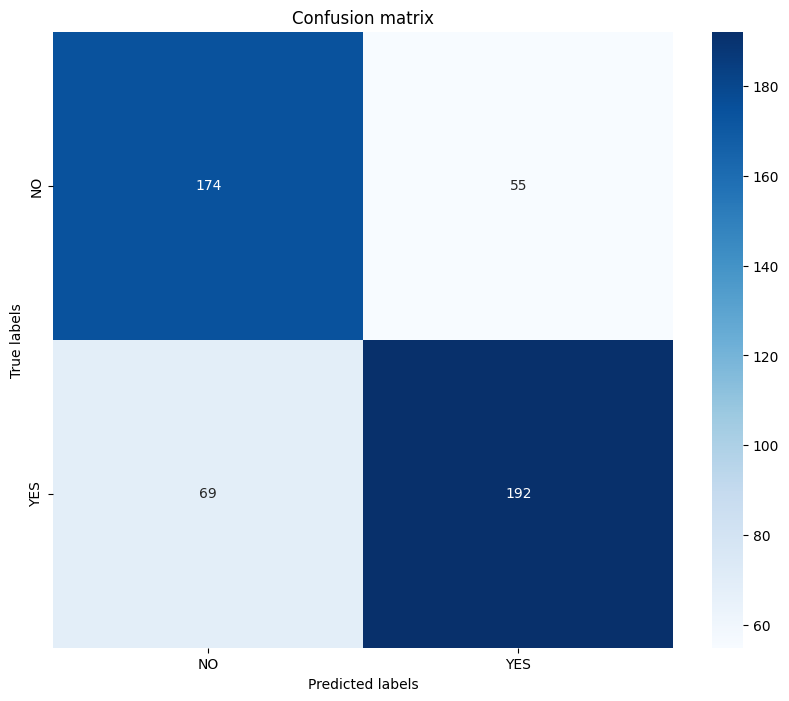

In [27]:
y_val = es_val_df_pt['label']
predicted_labels = np.argmax(output.predictions, axis=-1)

conf_matrix = confusion_matrix(y_true=y_val, y_pred=predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [29]:
examples=0

for i in range(len(y_val)):
    if y_val[i] != predicted_labels[i] and examples< 5:
        print(f"Text: {es_val_df_t['tweet'][i]}")
        print(f"True label: {y_val[i]}")
        print(f"Predicted label: {predicted_labels[i]}")
        print("\n")
        examples+=1

Text: Also mientras les decia eso la señalaba y decia que como el era del staff, la iban a ban de ese evento. Intel behavior much? Este cabron has sexually harassed women and girls en el community y cuando es confrontado, lo negative y mienta. Ahora salio con esta, HE should be banned.
True label: 1
Predicted label: 0


Text: @Ds_OutOfContext Micromachismo me recuerda a cuando en South park el directo PC gritaba MICROAGRESION!
True label: 1
Predicted label: 0


Text: ¿Cederle el paso a una Sra./Srta. en la cola del autobús como el asiento en un restaurante es:🔄 ¿Micromachismo?♥️ ¿O es una actitud       caballeresca y       respetuosa?
True label: 1
Predicted label: 0


Text: @EugeDF_ tal cual, rompemos el obelisco, quemamos muñecos con la cara de Jake Gyllenhaal al grito de you were tossing me the car keys fuck the patriarchy key chain on the ground y agarrate cuando arranque con dear John te traigo la cabeza de ese en una pica
True label: 0
Predicted label: 1


Text: “BAN VIAGRA!!!” 👇

C:\Users\nanni\AppData\Local\Temp\ipykernel_8644\922176362.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Text: {es_val_df_t['tweet'][i]}")


The performance of the models applied to the spanish tweets is lower than the performance of the models applied to the english tweets. This is probably due to the fact that the Spanish tweets are less in number and more noisy than the English tweets. Moreover, the Spanish GloVe embeddings are less accurate than the English GloVe embeddings, so the models have more difficulties in capturing the context of the tweets.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# The End